# Part2. Model design 2 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#load the original data
df1=pd.read_csv("../Data/kag_risk_factors_cervical_cancer.csv")

#load the processed datasets:
X_train=pd.read_csv("../Data/X_train_preprocessed.csv")
X_test=pd.read_csv("../Data/X_test_preprocessed.csv")
X_validate=pd.read_csv("../Data/X_validate_preprocessed.csv")
y_train=pd.read_csv("../Data/y_train_preprocessed.csv")
y_test=pd.read_csv("../Data/y_test_preprocessed.csv")
y_validate=pd.read_csv("../Data/y_validate_preprocessed.csv")

In [3]:
X_train.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
0,-1.531373,-0.302480,-1.064614,-0.836137,0.0,-0.307318,-0.208218,0.0,-0.556973,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.237878,1.427985,-0.001620,2.657531,1.0,-0.004815,0.325027,1.0,-0.412462,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.941623,-0.302480,-0.710283,-0.137403,0.0,-0.307318,-0.208218,1.0,-0.412462,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.823672,-0.302480,-0.710283,-0.836137,0.0,-0.307318,-0.208218,0.0,-0.556973,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.007129,0.274342,0.707042,-0.836137,0.0,-0.307318,-0.208218,0.0,-0.556973,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#show the processed X_train file:
X_train.tail(2)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology
654,-0.587772,-0.879301,-0.001620,-0.137403,0.0,-0.307318,-0.208218,1.0,-0.510729,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
655,0.355828,-0.302480,-1.418945,0.561330,1.0,4.945406,1.145403,0.0,-0.556973,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [42]:
y_train.tail(2)

,Biopsy
654,0
655,1


## Model

The data in unbalanced, let's try to correct the bias:

In [5]:
neg, pos = np.bincount(df1['Biopsy'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 858
    Positive: 55 (6.41% of total)



In [6]:
#compute an initial bias parameters, to teach the model positive examples are unlikely.
initial_bias = np.log([pos/neg])
initial_bias

array([-2.68102153])

In [7]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

EPOCHS = 100
BATCH_SIZE = 400

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model(output_bias=initial_bias) #initial bias parameter
model.predict(X_test)

model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                512       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [8]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Train the model with and without initial bias and compare outcomes:

In [11]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_validate, y_validate), 
    verbose=0)


In [12]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_validate, y_validate), 
    verbose=0)


In [13]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
    colorlist = ["blue", "darkorange"]
    plt.semilogy(history.epoch, history.history['loss'],
               color=colorlist[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colorlist[n], label='Val ' + label,
               linestyle="--")
    
    plt.legend()

    plt.xlabel('Epoch')
    plt.ylabel('Loss')


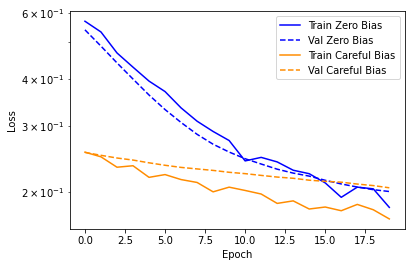

In [14]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


### Conclusion, using an initial bias reduces the loss of the model in thefirst epochs, but the validation loss after 15 epochs is not much different


In [123]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_validate, y_validate))



Epoch 1/100
21/21 [==============================] - 1s 35ms/step - loss: 0.2761 - tp: 0.0000e+00 - fp: 2.0000 - tn: 694.0000 - fn: 46.0000 - accuracy: 0.9353 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4753 - val_loss: 0.2231 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 81.0000 - val_fn: 5.0000 - val_accuracy: 0.9419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5531
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.2420 - tp: 0.0000e+00 - fp: 3.0000 - tn: 612.0000 - fn: 41.0000 - accuracy: 0.9329 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6187 - val_loss: 0.2188 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 81.0000 - val_fn: 5.0000 - val_accuracy: 0.9419 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5852
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 0.2514 - tp: 0.0000e+00 - fp: 2.0000 - tn: 613.0000 - fn: 41.0000 - accuracy: 0.9345 - precision: 0.0000e+00 - r

In [23]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

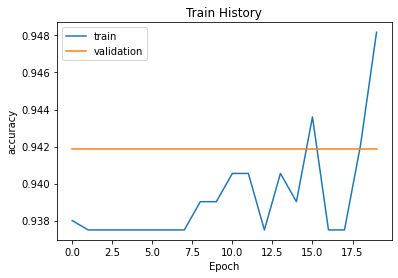

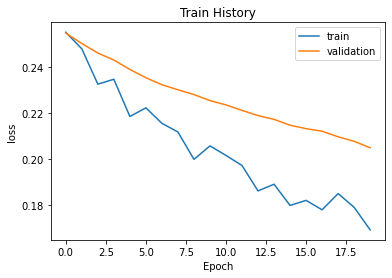

In [27]:
#visualize the loss and accuracy after each epoch
show_train_history(careful_bias_history,'accuracy','val_accuracy')
show_train_history(careful_bias_history,'loss','val_loss')


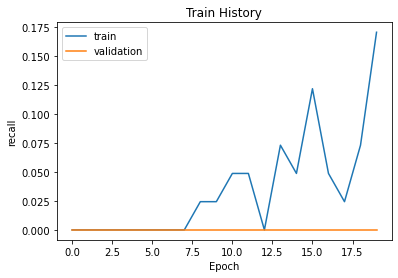

In [26]:
show_train_history(careful_bias_history,'recall','val_recall')

### The recall in this model is 0. It doesn't predict any cancer cases (of the 9 present)

In [33]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)


In [34]:
p=0.5
cm = confusion_matrix(y_test, test_predictions_baseline > p)


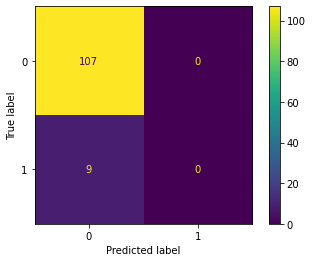

In [35]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [31]:
scores = model.evaluate(X_test, y_test)
print('\n')
print('recall=',scores[2])

4/4 [==============================] - 0s 5ms/step - loss: 0.2340 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 107.0000 - fn: 9.0000 - accuracy: 0.9224 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7819


recall= 0.0
